In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
pd.set_option('display.max_colwidth', None)

## Notebook 3 - Modeling

This is the last of 3 notebooks for this project.

In this notebook, I will:
- Combine the data from the 2 csv files
- Train test split the data
- Train multiple classification models using 2 types of vectorizers 
- Evaluate model performance
- Conclude and suggest potential next steps

----
## Load Data

In [2]:
theonion_df = pd.read_csv('../data/the_onion_lem.csv')
nottheonion_df = pd.read_csv('../data/not_the_onion_lem.csv')

Combining datasets of both subreddits

In [3]:
theonion_df['onion'] = 1
nottheonion_df['onion'] = 0

In [4]:
combined_df = pd.concat(objs = [theonion_df,nottheonion_df])
combined_df[['lem_title','onion']].head()

,lem_title,onion
0,abby lee miller cancer,1
1,amazon celebrates union defeat raising price 150 anyway,1
2,new arkansas bill would require teen resident keep genitals full display time,1
3,way prevent say nation regularly happens,1
4,panther adopt patchy haired shivering rescue qb spent year abused jet,1


In [5]:
combined_df[['lem_title','onion']].tail()

,lem_title,onion
995,call thespian actor say nicolas cage,0
996,giuffre lawyer seek detail prince andrew claimed inability sweat,0
997,betty white dead 99,0
998,central texas red cross sending least one volunteer colorado devastating fire,0
999,virginia giuffre lawyer demand proof prince andrew sweat,0


----
## Split the data into train and test datasets

In [6]:
X = combined_df['lem_title']
y = combined_df['onion']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [7]:
#instantiate a list to store model results
results = []

----
## Vectorize data before data modeling
To prepare the text information for the machine learning model, a vectorizer is used before the data is used for model fitting and learning.

In this project, 2 types of Vectorizers will be used for each type of machine learning model.

1) **Count Vectorizer:**
Counts how many times a token is observed in the selected text. Then, create a column for each unique token to store the counts.

2) **TFIDF Vectorizer:**
TFIDF stands for Term Frequency Inverse Document Frequency. It basically makes use of the property that words that are rare across some texts but are common across others are helpful in modeling.

----
## Data Modeling

### Baseline Model

The Dummy Classifier makes predictions that ignore the input features and is normally used as a baseline comparison to more complex classifier models.

In [8]:
%%time
pipe = Pipeline([('cvec', CountVectorizer()),('baseline', DummyClassifier(strategy="most_frequent",random_state=42))])

pipe_params = {
    'cvec__max_features':[1_000,2_000,3_000,4_000,5_000],
    'cvec__ngram_range':[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]
}

cvec_baseline_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
cvec_baseline_gs.fit(X_train, y_train)
print(cvec_baseline_gs.best_score_)
print(cvec_baseline_gs.best_params_)
print(cvec_baseline_gs.score(X_train, y_train))
print(cvec_baseline_gs.score(X_test, y_test))

cvec_baseline = []
cvec_baseline.append('cvec_baseline')
cvec_baseline.append(cvec_baseline_gs.score(X_train, y_train))
cvec_baseline.append(cvec_baseline_gs.score(X_test, y_test))
cvec_baseline.append(cvec_baseline_gs.best_score_)
cvec_baseline.append(cvec_baseline_gs.best_params_['cvec__max_features'])
cvec_baseline.append(cvec_baseline_gs.best_params_['cvec__ngram_range'])
results.append(cvec_baseline)

0.5
{'cvec__max_features': 1000, 'cvec__ngram_range': (1, 1)}
0.5
0.5
CPU times: total: 13.8 s
Wall time: 13.9 s


In [9]:
%%time
pipe = Pipeline([('tvec', TfidfVectorizer()),('baseline', DummyClassifier(strategy="most_frequent",random_state=42))])

pipe_params = {
    'tvec__max_features':[1_000,2_000,3_000,4_000,5_000],
    'tvec__ngram_range':[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]
}

tvec_baseline_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
tvec_baseline_gs.fit(X_train, y_train)
print(tvec_baseline_gs.best_score_)
print(tvec_baseline_gs.best_params_)
print(tvec_baseline_gs.score(X_train, y_train))
print(tvec_baseline_gs.score(X_test, y_test))

tvec_baseline = []
tvec_baseline.append('tvec_baseline')
tvec_baseline.append(tvec_baseline_gs.score(X_train, y_train))
tvec_baseline.append(tvec_baseline_gs.score(X_test, y_test))
tvec_baseline.append(tvec_baseline_gs.best_score_)
tvec_baseline.append(tvec_baseline_gs.best_params_['tvec__max_features'])
tvec_baseline.append(tvec_baseline_gs.best_params_['tvec__ngram_range'])
results.append(tvec_baseline)

0.5
{'tvec__max_features': 1000, 'tvec__ngram_range': (1, 1)}
0.5
0.5
CPU times: total: 13.5 s
Wall time: 13.6 s


### Multinomial Naive Bayes Model

The Naive Bayes model makes the naive assumption that all features in the data are independent of one another. 

Depending on the properties of the features, there are different types of Naive Bayes models that can be used. Such as Bernoulli Naive Bayes, Multinomial Naive Bayes and Gaussian Naive Bayes.

In this case, as the vectorizers will produce variables that are positive integers, the Multinomial Naive Bayes model is used.

In [10]:
%%time
pipe = Pipeline([('cvec', CountVectorizer()),('nb', MultinomialNB())])

pipe_params = {
    'cvec__max_features':[1_000,2_000,3_000,4_000,5_000],
    'cvec__ngram_range':[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]
}

cvec_nb_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
cvec_nb_gs.fit(X_train, y_train)
print(cvec_nb_gs.best_score_)
print(cvec_nb_gs.best_params_)
print(cvec_nb_gs.score(X_train, y_train))
print(cvec_nb_gs.score(X_test, y_test))

cvec_nb = []
cvec_nb.append('cvec_nb')
cvec_nb.append(cvec_nb_gs.score(X_train, y_train))
cvec_nb.append(cvec_nb_gs.score(X_test, y_test))
cvec_nb.append(cvec_nb_gs.best_score_)
cvec_nb.append(cvec_nb_gs.best_params_['cvec__max_features'])
cvec_nb.append(cvec_nb_gs.best_params_['cvec__ngram_range'])
results.append(cvec_nb)

0.7146666666666667
{'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2)}
0.9373333333333334
0.736
CPU times: total: 13.3 s
Wall time: 13.3 s


In [11]:
%%time
pipe = Pipeline([('tvec', TfidfVectorizer()),('nb', MultinomialNB())])

pipe_params = {
    'tvec__max_features':[1_000,2_000,3_000,4_000,5_000,6_000,7_000],
    'tvec__ngram_range':[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]
}

tvec_nb_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
tvec_nb_gs.fit(X_train, y_train)
print(tvec_nb_gs.best_score_)
print(tvec_nb_gs.best_params_)
print(tvec_nb_gs.score(X_train, y_train))
print(tvec_nb_gs.score(X_test, y_test))

tvec_nb = []
tvec_nb.append('tvec_nb')
tvec_nb.append(tvec_nb_gs.score(X_train, y_train))
tvec_nb.append(tvec_nb_gs.score(X_test, y_test))
tvec_nb.append(tvec_nb_gs.best_score_)
tvec_nb.append(tvec_nb_gs.best_params_['tvec__max_features'])
tvec_nb.append(tvec_nb_gs.best_params_['tvec__ngram_range'])
results.append(tvec_nb)

0.7173333333333334
{'tvec__max_features': 7000, 'tvec__ngram_range': (1, 2)}
0.9826666666666667
0.764
CPU times: total: 18.7 s
Wall time: 18.8 s


### Random Forest Model

The Random Forest Model is a type of ensemble model. By bootstrapping the data (taking random samples of the same size with replacement), it generates multiple decision tree models. 

Due to bootstrap samples being generated from the same original data, the decision trees are highly correlated. To counter this correlation between base trees, the Random Forest model uses the random subspace method. This means that at each split in the learning process of the decision trees, a random subset of features is selected instead of using all of them. 

Less correlation between trees means a stronger model.

In [12]:
%%time
pipe = Pipeline([('cvec', CountVectorizer()),('rf', RandomForestClassifier(random_state=42))])

pipe_params = {
    'cvec__max_features':[1_000,2_000,3_000],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2],    
}

cvec_rf_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
cvec_rf_gs.fit(X_train, y_train)
print(cvec_rf_gs.best_score_)
print(cvec_rf_gs.best_params_)
print(cvec_rf_gs.score(X_train, y_train))
print(cvec_rf_gs.score(X_test, y_test))

cvec_rf = []
cvec_rf.append('cvec_rf')
cvec_rf.append(cvec_rf_gs.score(X_train, y_train))
cvec_rf.append(cvec_rf_gs.score(X_test, y_test))
cvec_rf.append(cvec_rf_gs.best_score_)
cvec_rf.append(cvec_rf_gs.best_params_['cvec__max_features'])
cvec_rf.append(cvec_rf_gs.best_params_['cvec__ngram_range'])
results.append(cvec_rf)

0.686
{'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'rf__max_depth': None, 'rf__n_estimators': 150}
0.996
0.74
CPU times: total: 5min 50s
Wall time: 5min 51s


In [13]:
%%time
pipe = Pipeline([('tvec', TfidfVectorizer()),('rf', RandomForestClassifier(random_state=42))])

pipe_params = {
    'tvec__max_features':[1_000,2_000,3_000],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2],    
}

tvec_rf_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
tvec_rf_gs.fit(X_train, y_train)
print(tvec_rf_gs.best_score_)
print(tvec_rf_gs.best_params_)
print(tvec_rf_gs.score(X_train, y_train))
print(tvec_rf_gs.score(X_test, y_test))

tvec_rf = []
tvec_rf.append('tvec_rf')
tvec_rf.append(tvec_rf_gs.score(X_train, y_train))
tvec_rf.append(tvec_rf_gs.score(X_test, y_test))
tvec_rf.append(tvec_rf_gs.best_score_)
tvec_rf.append(tvec_rf_gs.best_params_['tvec__max_features'])
tvec_rf.append(tvec_rf_gs.best_params_['tvec__ngram_range'])
results.append(tvec_rf)

0.672
{'rf__max_depth': None, 'rf__n_estimators': 100, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 1)}
0.9973333333333333
0.726
CPU times: total: 5min 46s
Wall time: 5min 49s


## Support Vector Machines (SVM)
SVM tries to plot a separating hyperplane between datapoints of different classes. The best separating hyperplane is the one that creates the maximal margin (widest space around which there are no datapoints inside). The points touching the margin exactly are called support vectors.

SVM has been widely used historically and is generally effective in high dimensional data. However, the drawback is that this is generally a blackbox method with low interpretability.

In [14]:
%%time
pgrid = {"C": np.linspace(0.0001, 2, 10)}
pipe = Pipeline([('cvec', CountVectorizer()),('svc', LinearSVC())])

pipe_params = {
    'cvec__max_features':[1_000,2_000,3_000],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'svc__max_iter': [20_000],
    'svc__class_weight': ['balanced'],    
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cvec_svc_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = cv)
cvec_svc_gs.fit(X_train, y_train)
print(cvec_svc_gs.best_score_)
print(cvec_svc_gs.best_params_)
print(cvec_svc_gs.score(X_train, y_train))
print(cvec_svc_gs.score(X_test, y_test))

cvec_svc = []
cvec_svc.append('cvec_svc')
cvec_svc.append(cvec_svc_gs.score(X_train, y_train))
cvec_svc.append(cvec_svc_gs.score(X_test, y_test))
cvec_svc.append(cvec_svc_gs.best_score_)
cvec_svc.append(cvec_svc_gs.best_params_['cvec__max_features'])
cvec_svc.append(cvec_svc_gs.best_params_['cvec__ngram_range'])
results.append(cvec_svc)

0.6846666666666666
{'cvec__max_features': 3000, 'cvec__ngram_range': (1, 2), 'svc__class_weight': 'balanced', 'svc__max_iter': 20000}
0.996
0.686
CPU times: total: 5.09 s
Wall time: 5.11 s


In [15]:
%%time
pgrid = {"C": np.linspace(0.0001, 2, 10)}
pipe = Pipeline([('tvec', TfidfVectorizer()),('svc', LinearSVC())])

pipe_params = {
    'tvec__max_features':[1_000,2_000,3_000],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'svc__max_iter': [20_000],
    'svc__class_weight': ['balanced'],    
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tvec_svc_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = cv)
tvec_svc_gs.fit(X_train, y_train)
print(tvec_svc_gs.best_score_)
print(tvec_svc_gs.best_params_)
print(tvec_svc_gs.score(X_train, y_train))
print(tvec_svc_gs.score(X_test, y_test))

tvec_svc = []
tvec_svc.append('tvec_svc')
tvec_svc.append(tvec_svc_gs.score(X_train, y_train))
tvec_svc.append(tvec_svc_gs.score(X_test, y_test))
tvec_svc.append(tvec_svc_gs.best_score_)
tvec_svc.append(tvec_svc_gs.best_params_['tvec__max_features'])
tvec_svc.append(tvec_svc_gs.best_params_['tvec__ngram_range'])
results.append(tvec_svc)

0.6973333333333334
{'svc__class_weight': 'balanced', 'svc__max_iter': 20000, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2)}
0.9926666666666667
0.71
CPU times: total: 4.64 s
Wall time: 4.67 s


## Logistic Regression

Logistic Regression is a statistical model that uses a logistic function to model a binary dependent variable.

The odds for probability p of an outcome happening is defined as p/(1-p) or probability of something happening divided by probability of something not happening. A log function is then applied to this to produce a value between 0 and 1. A decided threshold can then be used to classify if an observation should be class 0 or 1 depending on the value produced from the log function. This value is 0.5 by default.

In [16]:
%%time
pipe = Pipeline([('cvec', CountVectorizer()),('logreg', LogisticRegression(random_state=42))])

pipe_params = {
    'cvec__max_features':[1_000,2_000,3_000,4_000,5_000],
    'cvec__ngram_range':[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]
    }

cvec_logreg_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
cvec_logreg_gs.fit(X_train, y_train)
print(cvec_logreg_gs.best_score_)
print(cvec_logreg_gs.best_params_)
print(cvec_logreg_gs.score(X_train, y_train))
print(cvec_logreg_gs.score(X_test, y_test))

cvec_lr = []
cvec_lr.append('cvec_logreg')
cvec_lr.append(cvec_logreg_gs.score(X_train, y_train))
cvec_lr.append(cvec_logreg_gs.score(X_test, y_test))
cvec_lr.append(cvec_logreg_gs.best_score_)
cvec_lr.append(cvec_logreg_gs.best_params_['cvec__max_features'])
cvec_lr.append(cvec_logreg_gs.best_params_['cvec__ngram_range'])
results.append(cvec_lr)

0.6973333333333334
{'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1)}
0.994
0.72
CPU times: total: 18.6 s
Wall time: 18.7 s


In [17]:
%%time
pipe = Pipeline([('tvec', TfidfVectorizer()),('logreg', LogisticRegression(random_state=42))])

pipe_params = {
    'tvec__max_features':[1_000,2_000,3_000,4_000,5_000],
    'tvec__ngram_range':[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]
    }

tvec_logreg_gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
tvec_logreg_gs.fit(X_train, y_train)
print(tvec_logreg_gs.best_score_)
print(tvec_logreg_gs.best_params_)
print(tvec_logreg_gs.score(X_train, y_train))
print(tvec_logreg_gs.score(X_test, y_test))

tvec_lr = []
tvec_lr.append('tvec_logreg')
tvec_lr.append(tvec_logreg_gs.score(X_train, y_train))
tvec_lr.append(tvec_logreg_gs.score(X_test, y_test))
tvec_lr.append(tvec_logreg_gs.best_score_)
tvec_lr.append(tvec_logreg_gs.best_params_['tvec__max_features'])
tvec_lr.append(tvec_logreg_gs.best_params_['tvec__ngram_range'])
results.append(tvec_lr)

0.706
{'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1)}
0.968
0.736
CPU times: total: 16.9 s
Wall time: 17 s


----
## Model Selection

The models are named in the form of vectorizer_model. E.g. tvec_nb means TFIDF Vectorizer into Multinomial Naive Bayes.

In [18]:
results = pd.DataFrame(results, columns = ['Model','Train Accuracy Score','Test Accuracy Score', 'Cross Validation Score', 'Max Features','Ngram Range'])
results

,Model,Train Accuracy Score,Test Accuracy Score,Cross Validation Score,Max Features,Ngram Range
0,cvec_baseline,0.500000,0.500,0.500000,1000,"(1, 1)"
1,tvec_baseline,0.500000,0.500,0.500000,1000,"(1, 1)"
2,cvec_nb,0.937333,0.736,0.714667,4000,"(1, 2)"
3,tvec_nb,0.982667,0.764,0.717333,7000,"(1, 2)"
4,cvec_rf,0.996000,0.740,0.686000,2000,"(1, 1)"
5,tvec_rf,0.997333,0.726,0.672000,3000,"(1, 1)"
6,cvec_svc,0.996000,0.686,0.684667,3000,"(1, 2)"
7,tvec_svc,0.992667,0.710,0.697333,3000,"(1, 2)"
8,cvec_logreg,0.994000,0.720,0.697333,5000,"(1, 1)"
9,tvec_logreg,0.968000,0.736,0.706000,4000,"(1, 1)"


In [19]:
results.sort_values(by=['Test Accuracy Score'], ascending = False)

,Model,Train Accuracy Score,Test Accuracy Score,Cross Validation Score,Max Features,Ngram Range
3,tvec_nb,0.982667,0.764,0.717333,7000,"(1, 2)"
4,cvec_rf,0.996000,0.740,0.686000,2000,"(1, 1)"
2,cvec_nb,0.937333,0.736,0.714667,4000,"(1, 2)"
9,tvec_logreg,0.968000,0.736,0.706000,4000,"(1, 1)"
5,tvec_rf,0.997333,0.726,0.672000,3000,"(1, 1)"
8,cvec_logreg,0.994000,0.720,0.697333,5000,"(1, 1)"
7,tvec_svc,0.992667,0.710,0.697333,3000,"(1, 2)"
6,cvec_svc,0.996000,0.686,0.684667,3000,"(1, 2)"
0,cvec_baseline,0.500000,0.500,0.500000,1000,"(1, 1)"
1,tvec_baseline,0.500000,0.500,0.500000,1000,"(1, 1)"


**Insights**
- Baseline models have scores of 50% which is reflective of the dataset having 50% posts from each subreddit.
- Test Scores for all non-baseline models are very high, with all of them above 95%
- Between Count Vectorizer and TFIDF Vectorizer, TFIDF performed better for all non-baseline models except for the Random Forest model
- Except for the 2 Random Forest models, all other models performed the best with unigrams, i.e. Ngram Range = (1,1)

**Model Selection**
- As the dataset is balanced, i.e. split 50/50 between posts from The Onion and Not The Onion, Accuracy Score will be a good evaluation metric
- Since Train Scores are very high for all non-baseline models, it will not be an important factor when determining the best performing model
- Shortlist the 3 models with the highest accuracy scores and dive deeper into the results using the Confusion Matrix
- As there are 3 models tied for 2nd place in terms of test score, to look at confusion matrix of top 4 models

## Confusion Matrix
- Posts from The Onion are set as class 1 and posts from Not The Onion are set as class 0
- In this case, class 1 will be used as "positive" and class 0 as "negative"

There are 4 types of predictions:
- True Positive: Model predicts that post is from The Onion and post is from The Onion (correct prediction)
- True Negative: Model predicts that post is from Not The Onion and post is from Not The Onion (correct prediction)
- False Positive: Model predicts that post is from The Onion but post is from Not The Onion (wrong prediction)
- False Negative: Model predicts that post is from Not The Onion but post is from The Onion (wrong prediction)

Text(0.5, 1.0, 'TFIDF Vectorizer into Multinomial Naive Bayes (tvec_nb)')

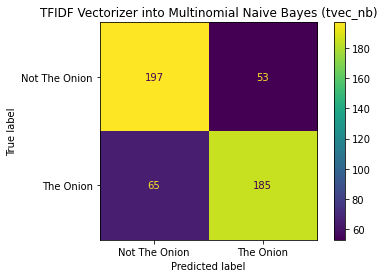

In [20]:
tvec_nb_pred = tvec_nb_gs.predict(X_test)
tvec_nb_cm = confusion_matrix(y_test, tvec_nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = tvec_nb_cm, display_labels = ['Not The Onion','The Onion'])
disp.plot()
tn, fp, fn, tp = confusion_matrix(y_test,tvec_nb_pred).ravel()
tvec_nb_pred_list = ['tvec_nb', tn, fp, fn, tp]
disp.ax_.set_title('TFIDF Vectorizer into Multinomial Naive Bayes (tvec_nb)')

Text(0.5, 1.0, 'Count Vectorizer into Multinomial Naive Bayes (cvec_nb)')

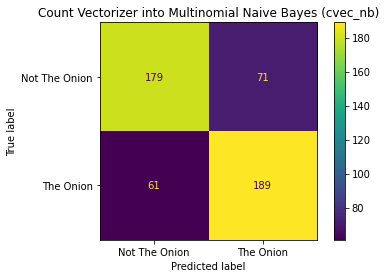

In [21]:
cvec_nb_pred = cvec_nb_gs.predict(X_test)
cvec_nb_cm = confusion_matrix(y_test, cvec_nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cvec_nb_cm, display_labels = ['Not The Onion','The Onion'])
disp.plot()
tn, fp, fn, tp = confusion_matrix(y_test,cvec_nb_pred).ravel()
cvec_nb_pred_list = ['cvec_nb', tn, fp, fn, tp]
disp.ax_.set_title('Count Vectorizer into Multinomial Naive Bayes (cvec_nb)')

Text(0.5, 1.0, 'Count Vectorizer into Random Forest (cvec_rf)')

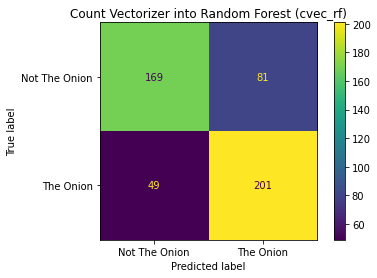

In [22]:
cvec_rf_pred = cvec_rf_gs.predict(X_test)
cvec_rf_cm = confusion_matrix(y_test, cvec_rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cvec_rf_cm, display_labels = ['Not The Onion','The Onion'])
disp.plot()
tn, fp, fn, tp = confusion_matrix(y_test,cvec_rf_pred).ravel()
cvec_rf_pred_list = ['cvec_rf', tn, fp, fn, tp]
disp.ax_.set_title('Count Vectorizer into Random Forest (cvec_rf)')

Text(0.5, 1.0, 'TFIDF Vectorizer into Logistic Regression (tvec_logreg)')

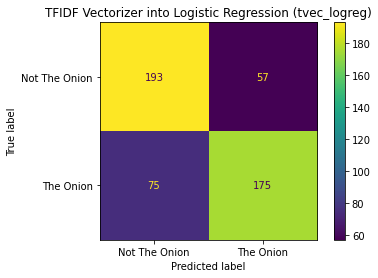

In [23]:
tvec_logreg_pred = tvec_logreg_gs.predict(X_test)
tvec_logreg_cm = confusion_matrix(y_test, tvec_logreg_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = tvec_logreg_cm, display_labels = ['Not The Onion','The Onion'])
disp.plot()
tn, fp, fn, tp = confusion_matrix(y_test,tvec_logreg_pred).ravel()
tvec_logreg_pred_list = ['tvec_logreg', tn, fp, fn, tp]
disp.ax_.set_title('TFIDF Vectorizer into Logistic Regression (tvec_logreg)')

In [24]:
confusion_matrix_results = [tvec_nb_pred_list, cvec_nb_pred_list, cvec_rf_pred_list, tvec_logreg_pred_list]
confusion_matrix_df = pd.DataFrame(confusion_matrix_results, columns = ['Model','True Negative','False Positive','False Negative','True Positive'])
confusion_matrix_df['Total Positive Predictions'] = confusion_matrix_df['True Positive'] + confusion_matrix_df['False Positive']
confusion_matrix_df['Total Negative Predictions'] = confusion_matrix_df['True Negative'] + confusion_matrix_df['False Negative']
confusion_matrix_df['Test Accuracy Score'] = (confusion_matrix_df['True Negative'] + confusion_matrix_df['True Positive'])/(confusion_matrix_df['False Negative'] + confusion_matrix_df['False Positive'] + confusion_matrix_df['True Negative'] + confusion_matrix_df['True Positive'])
confusion_matrix_df['Recall'] = confusion_matrix_df['True Positive']/(confusion_matrix_df['False Negative'] + confusion_matrix_df['True Positive'])
confusion_matrix_df['Specificity'] = confusion_matrix_df['True Negative']/(confusion_matrix_df['False Positive'] + confusion_matrix_df['True Negative'])
confusion_matrix_df['Precision'] = confusion_matrix_df['True Positive']/(confusion_matrix_df['False Positive'] + confusion_matrix_df['True Positive'])
confusion_matrix_df['Negative Predictive Value'] = confusion_matrix_df['True Negative']/(confusion_matrix_df['False Negative'] + confusion_matrix_df['True Negative'])
confusion_matrix_df

,Model,True Negative,False Positive,False Negative,True Positive,Total Positive Predictions,Total Negative Predictions,Test Accuracy Score,Recall,Specificity,Precision,Negative Predictive Value
0,tvec_nb,197,53,65,185,238,262,0.764,0.740,0.788,0.777311,0.751908
1,cvec_nb,179,71,61,189,260,240,0.736,0.756,0.716,0.726923,0.745833
2,cvec_rf,169,81,49,201,282,218,0.740,0.804,0.676,0.712766,0.775229
3,tvec_logreg,193,57,75,175,232,268,0.736,0.700,0.772,0.754310,0.720149


**Interpreting the scores:**
- Accuracy Score: Out of all posts, how many % of the model's predictions were correct?
- Recall Score: Out of all the The Onion posts, how many % of the model's The Onion predictions were correct?
- Specificity Score: Out of all the Not The Onion posts, how many % of the model's Not The Onion predictions were correct?
- Precision Score: Out of all the The Onion predictions, how many % were correct?
- Negative Predictive Value: Out of all the Not The Onion predictions, how many % were correct?

**Insights:**
- The model with the highest Test Accuracy Score is tvec_nb
- Even though there are 3 models with the same Accuracy Score, their scores in the other categories are not the same
- cvec_rf has the highest Recall score, getting 79.2% of all The Onion posts correct. However, this is achieved by a disproportionate number of The Onion predictions (279 out of 500) and the lowest Precision score at 71%. In other words, cvec_rf predicted a high number of posts as The Onion and even though it got the highest number of The Onion predictions correct, the Accuracy Score for each The Onion prediction is low.
- tvec_nb did the same, but for Not The Onion posts. It has the highest Specificity score, getting 82.4% of all the Not The Onion posts correct. This was also achieved by a disproportionate number of Not The Onion predictions (282 out of 500). However, its Negative Predictive Value is actually the second highest at 73%. This contributes to explaining why this model has the highest Test Accuracy Score.

**Choosing the best model:**
- As the data science team of Reddit, we should be impartial towards moderators of each subreddit.
- To be fair to the subreddits, we want to pick a model that is ideally equally accurate at predicting for either subreddit
- Given that this is the 1st iteration of the automoderator, the human moderators probably do not expect the predictions to be perfect, so we want to pick the model with the more balanced predictions (i.e. ratio of total negative predictions to total positive predictions to be close to 1.0, "Ratio of predictions" in table below)
- The aim of the automoderator is to classify posts correctly so the human moderators can get more work taken off them. Conversely, predicting a post wrongly will result in more work for the human moderators and we want to spread this evenly across the 2 subreddits (i.e. ratio of false negatives to false positives to be close to 1.0, "Ratio of false predictions" in table below)


In [25]:
confusion_matrix_df['Ratio of predictions'] = confusion_matrix_df['Total Negative Predictions']/confusion_matrix_df['Total Positive Predictions']
confusion_matrix_df['Ratio of false predictions'] = confusion_matrix_df['False Negative']/confusion_matrix_df['False Positive']
confusion_matrix_df

,Model,True Negative,False Positive,False Negative,True Positive,Total Positive Predictions,Total Negative Predictions,Test Accuracy Score,Recall,Specificity,Precision,Negative Predictive Value,Ratio of predictions,Ratio of false predictions
0,tvec_nb,197,53,65,185,238,262,0.764,0.740,0.788,0.777311,0.751908,1.100840,1.226415
1,cvec_nb,179,71,61,189,260,240,0.736,0.756,0.716,0.726923,0.745833,0.923077,0.859155
2,cvec_rf,169,81,49,201,282,218,0.740,0.804,0.676,0.712766,0.775229,0.773050,0.604938
3,tvec_logreg,193,57,75,175,232,268,0.736,0.700,0.772,0.754310,0.720149,1.155172,1.315789


**Most balanced model:**
- tvec_logreg is selected as the most balanced model as it has the closest ratios to the ideal 1.0

**Additional Advantage:**
- A Logistic Regression model is not a blackbox model so we are able to look at the high impact words that affect the classification

In [26]:
tvec_logreg_gs.best_params_

{'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1)}

In [27]:
#Unable to extract coefficients from gridsearch so refit the model manually
tvec = TfidfVectorizer(max_features=3000, ngram_range =(1,1))
X_tvec = tvec.fit_transform(X)
X_train_tvec, X_test_tvec, y_train, y_test = train_test_split(X_tvec, y, stratify = y, random_state=42)
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_tvec, y_train)

#create a dataframe consisting of the words and their respective coefficient, then sort them in descending order
logreg_coef = np.array(logreg.coef_).tolist()
logreg_coef = logreg_coef[0]
logreg_coef = pd.DataFrame(zip(tvec.get_feature_names(),logreg_coef), columns = ['word','coefficient']).sort_values(by = 'coefficient', ascending = False)
logreg_coef

c:\users\rohit\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,coefficient
1546,nation,1.957672
1046,god,1.633102
2605,thing,1.613052
1619,onion,1.565498
148,announces,1.563210
...,...,...
2459,squirrel,-1.150175
2485,stolen,-1.169717
1839,police,-1.465922
184,arrested,-1.514815


Text(0.5, 1.0, 'Most Impactful Words')

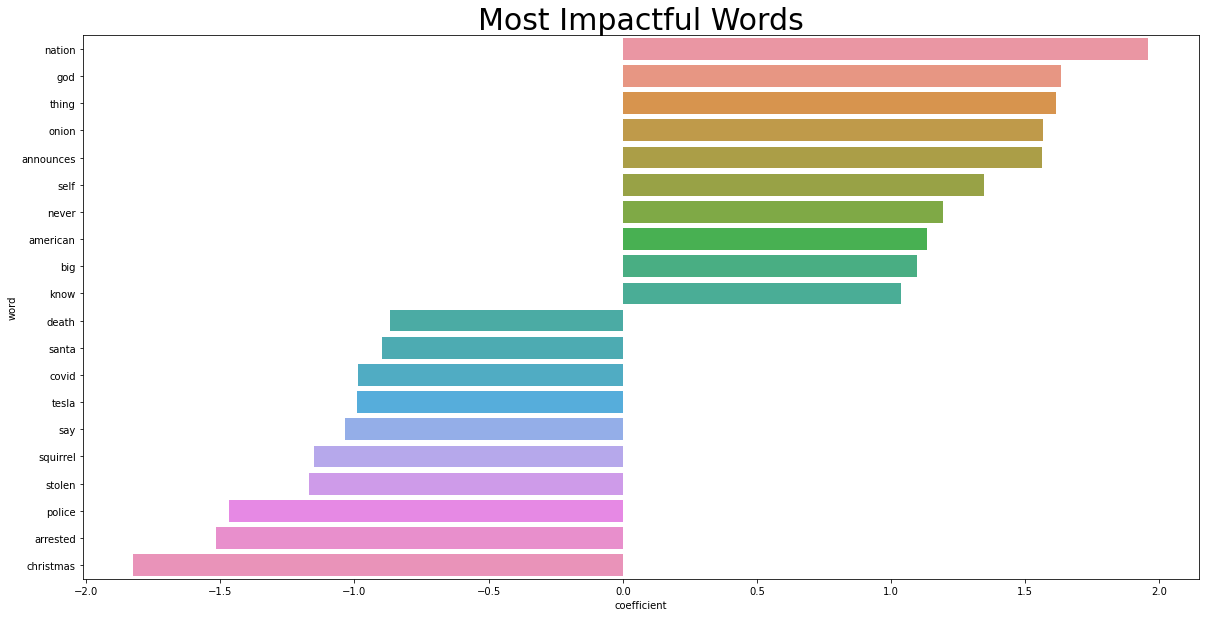

In [28]:
#The words with the most positive coefficients are the most impactful for classifying a post into The Onion. Similarly for negative coefficients and Not The Onion
#Only extract the top 10 most positive and top 10 most negative
theonion_coef = logreg_coef.head(10)
nottheonion_coef = logreg_coef.tail(10)
coef_combined = pd.concat([theonion_coef, nottheonion_coef], axis=0)

#plot a bar plot
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'coefficient', y= 'word', 
data=coef_combined)
plt.title('Most Impactful Words',{'fontsize':30})

**Observation:**
- The words with positive coefficients are the 10 most impactful in classifying a post into The Onion
- Impactful words for The Onion: nation, god, onion, announces, thing, self, never, american, know, big
- Conversely, words with negative coefficients are the 10 most impactful in classying a post into Not The Onion
- Impactful words for Not The Onion: death, santa, covid, tesla, squirrel, say, stolen, police, arrested, christmas

----
## Conclusion and Recommendations

**Best model for our requirements:**
- tvec_logreg is selected as the best model based on our evaluation metrics
- Even though it only has the second highest Test Accuracy Score, we are sacrificing a little bit of that to ensure more balanced predictions 
- The reduction of workload for human moderators in both subreddits will be more balanced and this will reflect well on us as we are being impartial 
- Additionally, a Logistic Regression model is not a blackbox model. Hence, we are able to identify high impact words that affect the classification

**Limitations:**
- The model is trained using posts from just before 1st January 2022, hence it may be skewed towards news topics that were popular during that time
- The model will not be able to account for changes in posting behavior should subreddit rules change drastically after 1st January 2022

**Future Improvements:**
- Scrape a larger number of posts to train the model
- In addition to just the title text, include other metadata from Reddit to train the model (e.g. author posting behavior, number of comments etc.)